# Load and inspect a seismic horizon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load the seismic

**The seismic data is too big for GitHub.**

The easiest thing to do is to download the HDF5 file:

* https://s3.amazonaws.com/agilegeo/Penobscot.h5 (about 120MB)

and put it into the data folder. Then you can just do this:

In [2]:
import h5py
with h5py.File('../data/Penobscot.h5','r') as h5f:
    seismic = h5f['amplitude'][:]

Or to read from SEG-Y, first [make sure you have ObsPy](https://github.com/obspy/obspy/wiki/Installation-via-Anaconda):

    conda config --add channels conda-forge
    conda install obspy

download https://s3.amazonaws.com/agilegeo/Penobscot_0-1000ms.sgy.gz and uncomment the following:


In [3]:
# import obspy
# filename = "../data/Penobscot_0-1000ms.sgy"
# section = obspy.read(filename)  # This gives a list of traces
# data = np.dstack([d for d in section])
# seismic = np.squeeze(data).reshape((251, 601, 481))

Or, to read from a NumPy file, download https://s3.amazonaws.com/agilegeo/Penobscot_NumPy.npy.gz and unzip it, then uncomment and run this block:

In [4]:
# seismic = np.load('../data/Penobscot.npy.gz')

To save in NumPy format:

In [5]:
# np.save('../data/Penobscot.npy', seismic)

Check everything looks OK:

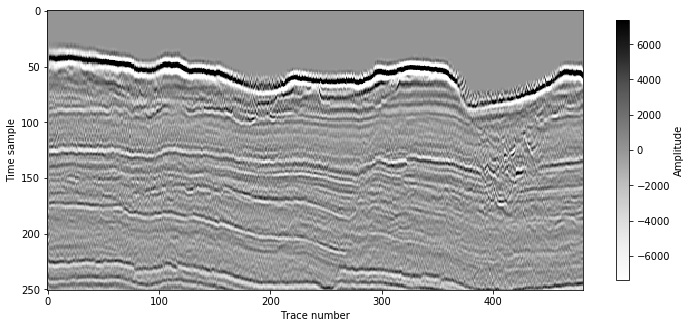

In [5]:
clip = np.percentile(seismic, 99)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.imshow(seismic[:,300,:], cmap="Greys", vmin=-clip, vmax=clip)
plt.colorbar(label="Amplitude", shrink=0.8)
ax.set_xlabel("Trace number")
ax.set_ylabel("Time sample")
plt.show()

## Load the horizon

In [6]:
horizon_data = np.loadtxt('../data/Penobscot_Seabed.txt')
horizon_data[:5]

array([[ 1003.        ,  1067.        ,   155.92899919],
       [ 1003.        ,  1068.        ,   156.3333571 ],
       [ 1003.        ,  1069.        ,   157.37710893],
       [ 1003.        ,  1070.        ,   157.56893158],
       [ 1003.        ,  1071.        ,   160.05718708]])

In [7]:
def regularize_horizon(horizon, extents, adj=(0,0)):
    output = np.empty(extents)
    output[:] = np.nan
    adj_x, adj_y = adj
    for (x, y, z) in horizon:
        output[int(x+adj_x), int(y+adj_y)] = z
    return output

In [8]:
sample_interval = 4  # ms
seabed = regularize_horizon(horizon_data, extents=(601, 481), adj=(-1000, -1000)) / sample_interval

Make a quick plot of -1 × the seabed, as a quick way to get the colourbar the right way up:

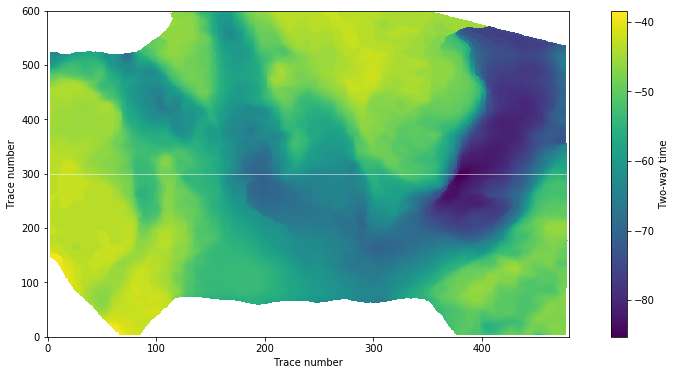

In [9]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.imshow(-seabed, aspect=0.5, cmap="viridis", origin='lower')
plt.colorbar(label="Two-way time")
ax.set_xlabel("Trace number")
ax.set_ylabel("Trace number")
ax.axhline(300, color='w', lw=0.5)
plt.show()

In [10]:
seismic.shape

(251, 601, 481)

## Extract amplitude

In [11]:
from scipy.interpolate import RegularGridInterpolator

In [12]:
# We need the data in yet another order!
s = np.swapaxes(seismic, 0, 2)
s = np.swapaxes(s, 0, 1)

# Provide the survey parameters.
x = np.linspace(1000, 1600, 601)  # Inline numbers
y = np.linspace(1000, 1480, 481)  # Crossline numbers
t = np.linspace(0, 1000, 251)  # ms

# Make an interpolator.
g = RegularGridInterpolator((x, y, t), s)

In [13]:
amplitudes = np.copy(horizon_data)
amplitudes[:,2] = g(horizon_data)

In [14]:
amps = regularize_horizon(amplitudes, (601, 481), adj=(-1000, -1000))

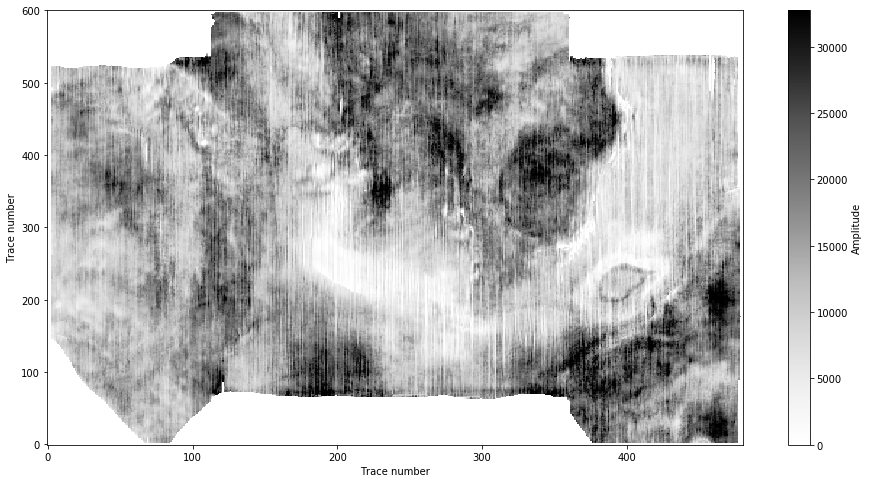

In [15]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plt.imshow(amps, cmap='Greys', origin='lower', aspect=0.5, vmin=0)
ax.set_ylabel("Trace number")
ax.set_xlabel("Trace number")
plt.colorbar(label="Amplitude")
plt.show()